# CNN+LRao detector: Student-t (including Cauchy) noise simulation

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy as sp
import CNN_LRao_functions as f
# %matplotlib widget
device = "cuda" if torch.cuda.is_available() else "cpu"

### Generate random AR filter

In [3]:
sys_len = 3

# to ensure randomly generated filter is stable
def reflection_to_ar(reflection_coeffs):
    order = len(reflection_coeffs)
    ar_coeffs = np.zeros(order + 1, dtype=np.float64)
    ar_coeffs[0] = 1.0
    for i in range(1, order + 1):
        k = reflection_coeffs[i-1]
        prev_a = ar_coeffs[:i].copy()
        if i > 1:
            ar_coeffs[1:i] = prev_a[1:] - k * prev_a[1:][::-1]
        ar_coeffs[i] = -k
    return ar_coeffs
a_coeffs = reflection_to_ar(np.random.rand(sys_len)-0.5)
b_coeffs = np.array([1])

# construct filter matrix for calcuation of FIM
def arma_filter_matrix(a_coeffs, b_coeffs, N):
    A = np.eye(N)
    for i in range(1, N):
        for k in range(1, len(a_coeffs)+1):
            if i-k >= 0:
                A[i, i-k] = a_coeffs[k-1]
    u,s,v = np.linalg.svd(A)
    s_inv = np.zeros(s.shape)
    cutoff = 1e-3
    s_inv[s>cutoff] = 1/s[s>cutoff]
    A_inv = v.T@np.diag(s_inv)@u.T
    Q = sp.linalg.toeplitz(np.concatenate([b_coeffs,np.zeros(N-len(b_coeffs))]),np.concatenate([b_coeffs[:1],np.zeros(N-1)]))
    u,s,v = np.linalg.svd(Q)
    s_inv = np.zeros(s.shape)
    cutoff = 1e-3
    s_inv[s>cutoff] = 1/s[s>cutoff]
    Q_inv = v.T@np.diag(s_inv)@u.T
    return A_inv@Q, Q_inv@A, A

### Hyperparameters: CNN, noise, and FI

In [ ]:
config = {
    "optim": "AdamW", # pytorch optimier for CNN weights
    "lr": 3e-4, # learning rate for optimizer
    "weight_decay": 1e-5, # L2 weight decay factor
    "dim_inp_train": 128, # dimension of CNN input data: training
    "dim_inp_val": 256, # dimension of CNN input data: validation
    "psd_method_params": {"name":"periodogram"}, # method of PSD estimation
    "max_iterations": 1000, # max training iterations (batches)
    "da": 3e-2, # step size Jacobian of mean
    "filt_size":3, # size of CNN filters
    "n_hidden_channels": 20, # number of CNN hidden channels
    "n_conv_layers": 3, # number of CNN layers (including first and last)
    "batch_size": 2**8, # batchsize for training
    "filt_coeffs": [a_coeffs,b_coeffs], # filter coefficients of linear filter acting upon noise
    "iter_batch": 1, # iterations of batches to accumulate gradient accross multiple batches
    "puffer_sides": 10 # puffer on sides of input layer for calculation of gradient to eliminate edge effects
}
_, A, _ = arma_filter_matrix(a_coeffs[1:],b_coeffs,config["dim_inp_val"]) # linear filter matrix for calculation of FIM
K = 4 # number of harmonics
psi0 = 0.1 # normalized fundamental frequency
H = f.H_multi_harmonic(K,psi0,config["dim_inp_train"]).to(device) # observation matrix train
H_test = f.H_multi_harmonic(K,psi0,config["dim_inp_val"]).to(device) # observation matrix test
nu = 2 # degrees of freedom for Student-t distribution (for nu=1 we get Cauchy distribution)
noise_gen = f.StudentT_noise_generator(nu,config["filt_coeffs"]) # noise generator
noise_test = noise_gen.gen_noise_sequences(config["dim_inp_val"],config["batch_size"]) # test noise for scale estimation
p_data = (1.483*np.median(np.abs(np.array(noise_test))))**2 # robust scale estimate of scale
n_SNR = 50 # number of considered SNR levels
snr = torch.logspace(-5,-1,n_SNR) # SNR levels
amplitudes = torch.sqrt(2*p_data*snr/K) # select amplitudes levels according to SNR levels
F = 1/2*(A.T)@A if nu==1 else (nu+1)/(nu+3)*(A.T)@A # ground truth FIM for objective comparison
Ftheta = (H_test.to(torch.float64).cpu().T)@F@H_test.to(torch.float64).cpu() # FIM w.r.t. theta

### Check FI and noise characteristics

(normalized) tract of FI: 92.6116206178362
[ 95.165124   130.26500489  39.91335973 106.26391961  93.78183497
 129.28025862  39.60081662 106.62264649]


Text(0, 0.5, 'noise value')

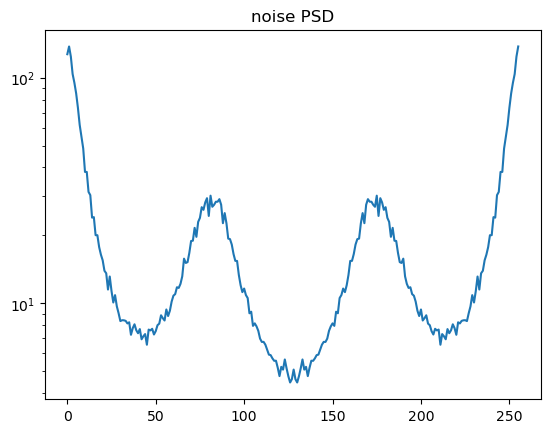

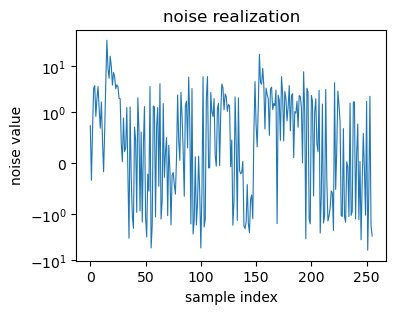

In [5]:
print("(normalized) tract of FI:",np.mean(np.diag(Ftheta)))
print(np.diag(Ftheta))
plt.figure()
plt.semilogy(np.mean(np.abs(np.fft.fft(noise_test,axis=1,norm="ortho"))**2,axis=0))
plt.title("noise PSD")
plt.figure(figsize=(4,3))
plt.plot(noise_test[1:2].T,linewidth=0.8)
plt.title("noise realization")
plt.yscale('symlog', linthresh=1)
plt.xlabel("sample index")
plt.ylabel("noise value")

### Train model

In [6]:
model = f.Trafo(config)
model = model.to(device)
lfi, model = f.train_data_sim(model,H,H_test,config,noise_gen)

  0%|          | 0/1000 [00:00<?, ?it/s]

lfi tensor([42.6759, 13.4501, 24.0668, 66.9244, 41.7826, 13.8157, 24.0054, 65.5125])
lfi tensor([45.8101, 47.7575, 24.6762, 70.9755, 44.7886, 48.0728, 24.9768, 69.3425])
lfi tensor([50.4660, 60.8282, 22.3570, 69.7680, 49.3745, 61.4925, 22.7570, 68.2521])
lfi tensor([57.1443, 86.7327, 24.2123, 77.2849, 56.3710, 87.6446, 24.9444, 75.7473])
lfi tensor([52.7749, 83.9850, 24.3031, 72.5257, 52.0914, 83.7579, 25.3951, 71.3328])
lfi tensor([57.5436, 71.1173, 22.8199, 72.3587, 56.2935, 70.6490, 23.6924, 70.1522])
lfi tensor([56.2632, 84.5564, 25.7116, 70.9437, 55.7899, 84.2686, 26.3550, 69.1167])
lfi tensor([60.8594, 87.3622, 21.7124, 79.4299, 59.6847, 86.4717, 22.5560, 77.2965])
lfi tensor([61.9282, 84.3690, 23.8947, 73.6231, 61.3358, 83.9689, 24.4817, 72.0411])
lfi tensor([64.1210, 80.6312, 23.8194, 71.3316, 62.8162, 81.1758, 24.6563, 70.7785])
lfi tensor([63.3854, 88.8804, 27.9258, 73.8244, 62.8199, 89.8619, 28.6544, 72.7767])
lfi tensor([63.5230, 94.5424, 25.6186, 79.7528, 62.2558, 94.7515,

Text(0, 0.5, 'tr$(\\hat{\\mathbf{J}_{\\boldsymbol{\\Psi}}})$/tr$(\\mathbf{F})$')

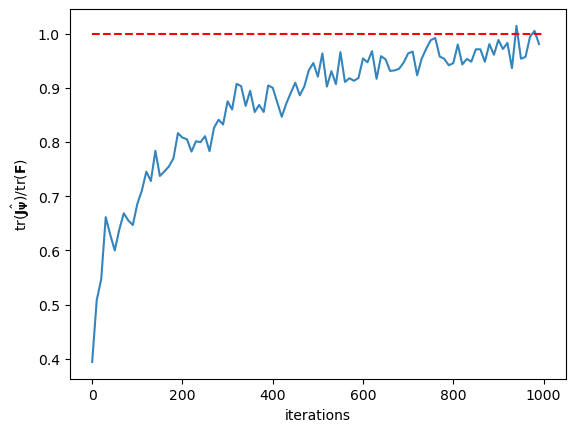

In [7]:
plt.figure()
plt.plot(np.arange(0,len(lfi)*10,10),[torch.mean(lfi[i]) for i in range(len(lfi))]/np.mean(np.diag(Ftheta)),alpha=0.9)
plt.plot([0,len(lfi)*10-1],[1,1],"r--")
plt.xlabel("iterations")
plt.ylabel(r"tr$(\hat{\mathbf{J}_{\boldsymbol{\Psi}}})$/tr$(\mathbf{F})$")

### Test model

In [ ]:
N = 512 # sequence length test data
batch_size_test = 2**10 #2**15
nu_ = nu # degrees of freedom (student t) for test distribution
noise_gen_ = noise_gen if nu_==nu else f.StudentT_noise_generator(nu_,config["filt_coeffs"])
H_test = f.H_multi_harmonic(K,psi0,N).to(device)
_, A, _ = arma_filter_matrix(a_coeffs[1:],b_coeffs,N)
F = (nu_+1)/(nu_+3)*(A.T)@A if nu_>1 else 1/2*(A.T)@A
Ftheta = (H_test.to(torch.float64).cpu().T)@F@H_test.to(torch.float64).cpu()
lambda_nc_theory = []
for i in range(len(amplitudes)):
    pfa = np.linspace(0,1,1000)
    thresholds = sp.stats.chi2.isf(pfa,df=2*K)
    phases = 2*torch.pi*np.random.rand(H.shape[1]//2,1)
    theta = np.zeros((H_test.shape[1],1))
    theta[:len(theta)//2] = amplitudes[i]*np.cos(phases)
    theta[len(theta)//2:] = -amplitudes[i]*np.sin(phases)
    lambda_nc_theory.append((theta.T@Ftheta.numpy()@theta).squeeze())

In [9]:
from tqdm.auto import tqdm
iter_test = 1 # iterations of batches
def test_model(model,H_test,amplitudes):
    data_stats = noise_gen.gen_noise_sequences(N,batch_size_test)
    data_stats = data_stats.to(device)
    model.eval()
    model.set_statistics_dft(data_stats.detach(),H_test)
    t0 = []
    t1 = []
    lambda_nc = torch.zeros(len(amplitudes),iter_test,dtype=torch.float32)
    for j in range(iter_test):
        data_test = noise_gen_.gen_noise_sequences(N,batch_size_test)
        data_test = data_test.to(device)
        t0.append(model.detect(data_test).cpu().squeeze())
        t1_ = [None]*len(amplitudes)
        for i in tqdm(range(len(amplitudes))):
            phases = 2*torch.pi*torch.rand((H.shape[1]//2,1),dtype=torch.float32,device=H.device)
            theta = torch.zeros((H_test.shape[1],1),device=H_test.device)
            theta[:len(theta)//2] = amplitudes[i]*torch.cos(phases)
            theta[len(theta)//2:] = -amplitudes[i]*torch.sin(phases)
            t1_[i] = model.calc_test_statistics(data_test.detach(),H_test,theta,H0=False).cpu().squeeze()
            if j==0:
                lambda_nc[i,j] = (theta.T@model.j0@theta).cpu().squeeze()
        t1.append(torch.stack(t1_,dim=0))
    return torch.concat(t0),torch.concat(t1,dim=1),torch.mean(lambda_nc,dim=1)
t0, t1, lambda_nc = test_model(model,H_test,amplitudes)


  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\Jonas Lindenberger\Dropbox\Fisher Information\Rao Detector\code submission\CNN_LRao_functions.py:199: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta = (torch.tensor(theta.clone()).reshape(-1,1)).to(x.device)


### Plot distributions

Text(0.5, 0, 'value of test statistic')

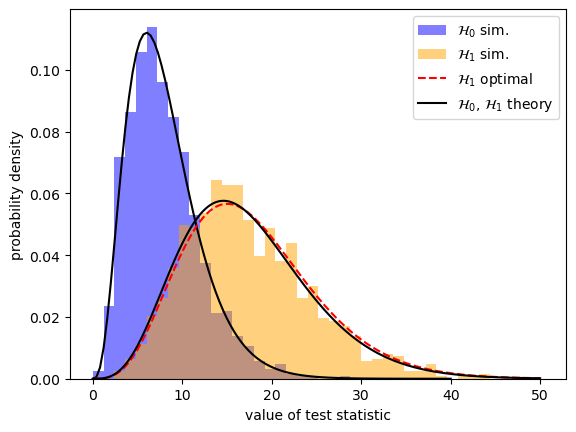

In [14]:
idx = 35 # SNR index
binwidth = 1.2 # histogram bin width
df = 2*K # degrees of freedom of asymptotic Chi-squared test statistic distribution
plt.figure()
plt.hist(t0,density=True,alpha=0.5,color="blue",bins=np.arange(0,50+binwidth,binwidth),label=r"$\mathcal{H}_0$ sim.")
plt.plot(np.linspace(0,40,100),sp.stats.chi2.pdf(np.linspace(0,40,100),df),color="k")
plt.hist(t1[idx],density=True,alpha=0.5,color="orange",bins=np.arange(0,50+binwidth,binwidth),label=r"$\mathcal{H}_1$ sim.")
plt.plot(np.linspace(0,50,200),sp.stats.ncx2.pdf(np.linspace(0,50,200),df,lambda_nc_theory[idx]),"r--",label=r"$\mathcal{H}_1$ optimal")
plt.plot(np.linspace(0,50,200),sp.stats.ncx2.pdf(np.linspace(0,50,200),df,lambda_nc[idx]),"k",label=r"$\mathcal{H}_0$, $\mathcal{H}_1$ theory")
plt.legend()
plt.ylabel("probability density")
plt.xlabel("value of test statistic")

### Plots ROCs

C:\Users\Jonas Lindenberger\AppData\Local\Temp\3\ipykernel_56860\4201975596.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.text(*pos[i],f"SNR={10*np.log10(snr[idx]):.2f}")


Text(0.5, 1.0, 'N=512')

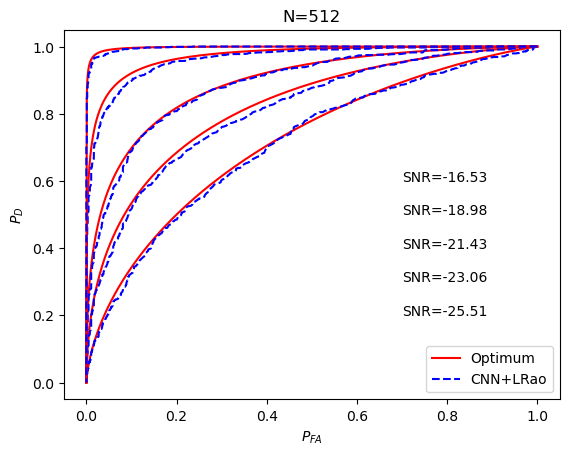

In [12]:
plt.figure()
pos = [
    [0.7,0.2],
    [0.7,0.3],
    [0.7,0.4],
    [0.7,0.5],
    [0.7,0.6]
]
pfa = np.linspace(0,1,1000)
thresholds = sp.stats.chi2.isf(pfa,df=2*K)
for i,idx in enumerate([30,33,35,38,41]):#[35,39,41,43,45]#[19,23,25,27,30]#[30,33,35,38,41]#[34,37,39,41,44]
    pd = sp.stats.ncx2.sf(thresholds,df=2*K,nc=lambda_nc_theory[idx])
    tpr,fpr = f.calc_roc_statistics(t0,t1[idx])
    plt.plot(pfa,pd,"r")
    plt.plot(fpr,tpr,"b--")
    plt.text(*pos[i],f"SNR={10*np.log10(snr[idx]):.2f}")
plt.xlabel(r"$P_{FA}$")
plt.ylabel(r"$P_{D}$")
plt.legend(["Optimum","CNN+LRao"])
plt.title(f"N={N}")